In [1]:
import os
import sys
from pathlib import Path

In [2]:
CURR_DIR = Path.cwd()
PROJECT_DIR = CURR_DIR.parent
DATA_DIR = Path(PROJECT_DIR, "data")
PROCESSED_DATA_DIR = Path(DATA_DIR, "processed")

IMG_DIR = Path(PROCESSED_DATA_DIR, "images")
MASK_DIR = Path(PROCESSED_DATA_DIR, "masks")

In [3]:
sys.path.append(PROJECT_DIR)

## Load Data

In [13]:
import torch
import numpy as np
from torch.utils.data import DataLoader,Dataset

from config import config
from src.data.dataloader import Data
from src.data.data_utils import extract_data_name

def _get_dataset_path(dataset_group:str) -> tuple[Path,Path]:
    
    return {
        "train": (
            config.TRAIN_IMG_DIR,
            config.TRAIN_MASK_DIR
        ),
        "valid": (
            config.VALID_IMG_DIR,
            config.VALID_MASK_DIR
        ),
        "test": (
            config.TEST_IMG_DIR,
            config.TEST_MASK_DIR
        )
    }[dataset_group]

def _get_filename_info(filename:str) -> list[str]:
    """Get the city, sequence, and frame from the filename.
    
    Ex.
        'strasbourg_000001_063385' -> ['strasbourg', '000001', '063385']
    """
    return extract_data_name(filename).split("_")

class CityScapesDataset(Dataset):
    def __init__(self, dataset_group:str, transform=None) -> None:
        img_path, mask_path = _get_dataset_path(dataset_group)
        
        img_names = sorted([extract_data_name(filename) for filename in os.listdir(img_path)])
        mask_names = sorted([extract_data_name(filename) for filename in os.listdir(mask_path)])
        
        assert len(img_names) == len(mask_names), "images and masks filenames must be the same"
        
        # check if images and masks filenames are the same
        # strasbourg_000001_063385 == strasbourg_000001_063385
        assert img_names == mask_names, "images and masks cities must be the same"
        
        self.data = [
            Data(*_get_filename_info(path), dataset_group)
            for path in os.listdir(img_path)
        ]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        image = self.data[index].load_array("image")
        mask = self.data[index].load_array("mask").astype(np.float32)
        
        if self.transform:
            augmented_data = self.transform(image=image, mask=mask)
            image:torch.Tensor = augmented_data["image"].float()
            mask:torch.Tensor = augmented_data["mask"].long()
        else:
            image = torch.from_numpy(image).float()
            mask = torch.from_numpy(mask).long()
        
        return image, mask

In [14]:
data_test = CityScapesDataset("train")
sample_mask = data_test.data[0].load_array("mask")

In [15]:
sample_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

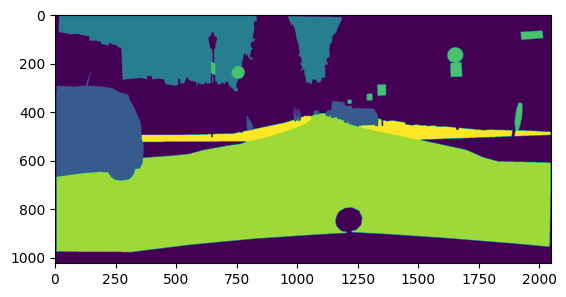

In [16]:
import matplotlib.pyplot as plt
plt.imshow(sample_mask)

In [17]:
classes = np.unique(sample_mask)
classes

array([0, 1, 2, 3, 5, 6, 7], dtype=uint8)

In [18]:
torch.from_numpy(sample_mask).long()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [19]:
"""
ignore_index = 250
classmap = {"label 1": 0, "label 2": 1, ...}

encode segmap:
- sets void classes to ignore_index
- update mask with new using classmap
"""

'\nignore_index = 250\nclassmap = {"label 1": 0, "label 2": 1, ...}\n\nencode segmap:\n- sets void classes to ignore_index\n- update mask with new using classmap\n'

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGE_HEIGHT = 224  # 1280 originally
IMAGE_WIDTH = 224  # 1918 originally

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [21]:
train_ds = CityScapesDataset("train",transform=train_transform)
valid_ds = CityScapesDataset("valid",transform=val_transform)
sample_img, sample_mask = train_ds[0]

print(sample_mask)

tensor([[0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        ...,
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6]])


In [22]:
batch_size = 1
train_loader = DataLoader(train_ds,batch_size)
valid_loader = DataLoader(valid_ds,batch_size)

In [23]:
import torch
import torch.nn as nn

torch.cuda.is_available()

True

## Load Model

In [24]:
from src.model.unet import UNET
from src.model.r2_unet import R2U_Net

device = "cuda" if torch.cuda.is_available() else "cpu"

# model = UNET(in_channels=3, out_channels=1).to(device)
model = R2U_Net(img_ch=3, output_ch=8).to(device)

## Loss Function and Optimiser

In [25]:
import torch.optim as optim
import torch.nn.functional as F
LEARNING_RATE = 1e-6

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Cross Entropy Loss adapted from meetshah1995 to prevent size inconsistencies between model precition 
# and target label
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loss/loss.py

def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=0#250
    )
    return loss

## Metrics

In [26]:
import sklearn.metrics as skm

'''We have used skelarn libraries to calculate Accuracy and Jaccard Score'''

def get_metrics(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)
    
    #Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')
    
    result_gm_sh = [acc, js]
    return(result_gm_sh)

'''
Calculation of confusion matrix from :
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/metrics.py

Added modifications to calculate 3 evaluation metrics - 
Specificity, Senstivity, F1 Score
'''

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        # confusion matrix
        hist = self.confusion_matrix
        
        #              T
        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FN   TN   TN       This is wrt to class 0
        #    2   FN   TN   TN

        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FP   TP   FP       This is wrt prediction classes; AXIS = 1
        #    2   FP   FP   TP 

        #         0    1    2
        #    0   TP   FN   FN
        #  P 1   FN   TP   FN       This is wrt true classes; AXIS = 0
        #    2   FN   FN   TP   

        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP
        
        # 1e-6 was added to prevent corner cases where denominator = 0
        
        # Specificity: TN / TN + FP
        specif_cls = (TN) / (TN + FP + 1e-6)
        specif = np.nanmean(specif_cls)
        
        # Senstivity/Recall: TP / TP + FN
        sensti_cls = (TP) / (TP + FN + 1e-6)
        sensti = np.nanmean(sensti_cls)
        
        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)
        
        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * sensti) / (prec + sensti + 1e-6)
        
        return (
            {
                "Specificity": specif,
                "Senstivity": sensti,
                "F1": f1,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

## Train

In [27]:
def train(train_loader, model, optimizer, epoch_i, epoch_total):
        count = 0
        
        # List to cumulate loss during iterations
        loss_list = []
        for (images, labels) in train_loader:
            count += 1
            
            # we used model.eval() below. This is to bring model back to training mood.
            model.train()

            images = images.to(device)
            labels = labels.to(device)
            
            # Model Prediction
            pred = model(images)
            
            # Loss Calculation
            loss = cross_entropy2d(pred, labels)
            loss_list.append(loss)

            # optimiser
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # interval to print train statistics
            if count % 50 == 0:
                fmt_str = "Image: {:d} in epoch: [{:d}/{:d}]  and Loss: {:.4f}"
                print_str = fmt_str.format(
                    count,
                    epoch_i + 1,
                    epoch_total,
                    loss.item()
                )
                print(print_str)
                   
#           # break for testing purpose
#             if count == 10:
#                 break
        return(loss_list)

In [28]:
from tqdm import tqdm

def validate(val_loader, model, epoch_i):
    
    # tldr: to make layers behave differently during inference (vs training)
    model.eval()
    
    # enable calculation of confusion matrix for n_classes = 19
    running_metrics_val = runningScore(8)
    
    # empty list to add Accuracy and Jaccard Score Calculations
    acc_sh = []
    js_sh = []
    
    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Model prediction
            val_pred = model(val_images)
            
            # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
            # considering predictions with highest scores for each pixel among 19 classes
            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = val_labels.data.cpu().numpy()
            
            # Updating Mertics
            running_metrics_val.update(gt, pred)
            sh_metrics = get_metrics(gt.flatten(), pred.flatten())
            acc_sh.append(sh_metrics[0])
            js_sh.append(sh_metrics[1])
                               
#            # break for testing purpose
#             if image_num == 10:
#                 break                

    score = running_metrics_val.get_scores()
    running_metrics_val.reset()
    
    acc_s = sum(acc_sh)/len(acc_sh)
    js_s = sum(js_sh)/len(js_sh)
    score["acc"] = acc_s
    score["js"] = js_s
    
    print("Different Metrics were: ", score)  
    return(score)

In [29]:
import time

TRAIN_EPOCHS = 5

if __name__ == "__main__":

    # to hold loss values after each epoch
    loss_all_epochs = []
    
    # to hold different metrics after each epoch
    Specificity_ = []
    Senstivity_ = []
    F1_ = []
    acc_ = []
    js_ = []
    
    for epoch_i in range(TRAIN_EPOCHS):
        # training
        print(f"Epoch {epoch_i + 1}\n-------------------------------")
        t1 = time.time()
        loss_i = train(train_loader, model, optimizer, epoch_i, TRAIN_EPOCHS)
        loss_all_epochs.append(loss_i)
        t2 = time.time()
        print("It took: ", t2-t1, " unit time")

        # metrics calculation on validation data
        dummy_list = validate(valid_loader, model, epoch_i)   
        
        # Add metrics to empty list above
        Specificity_.append(dummy_list["Specificity"])
        Senstivity_.append(dummy_list["Senstivity"])
        F1_.append(dummy_list["F1"])
        acc_.append(dummy_list["acc"])
        js_.append(dummy_list["js"])

Epoch 1
-------------------------------


/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/5]  and Loss: 1.8296
Image: 100 in epoch: [1/5]  and Loss: 1.7145
Image: 150 in epoch: [1/5]  and Loss: 1.6618
Image: 200 in epoch: [1/5]  and Loss: 1.4202
Image: 250 in epoch: [1/5]  and Loss: 1.4809
Image: 300 in epoch: [1/5]  and Loss: 1.3291
Image: 350 in epoch: [1/5]  and Loss: 1.2879
Image: 400 in epoch: [1/5]  and Loss: 1.1762
Image: 450 in epoch: [1/5]  and Loss: 1.3228
Image: 500 in epoch: [1/5]  and Loss: 1.2589
Image: 550 in epoch: [1/5]  and Loss: 0.8557
Image: 600 in epoch: [1/5]  and Loss: 1.0249
Image: 650 in epoch: [1/5]  and Loss: 0.9334
Image: 700 in epoch: [1/5]  and Loss: 1.0891
Image: 750 in epoch: [1/5]  and Loss: 1.4498
Image: 800 in epoch: [1/5]  and Loss: 0.9006
Image: 850 in epoch: [1/5]  and Loss: 0.9834
Image: 900 in epoch: [1/5]  and Loss: 1.4168
Image: 950 in epoch: [1/5]  and Loss: 1.3252
Image: 1000 in epoch: [1/5]  and Loss: 0.6757
Image: 1050 in epoch: [1/5]  and Loss: 0.7373
Image: 1100 in epoch: [1/5]  and Loss: 1.0201
Image: 1

500it [00:53,  9.40it/s]
/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9168891884673432, 'Senstivity': 0.2757893762293079, 'F1': 0.19885309427622738, 'acc': 0.3372263233418364, 'js': 0.20591700456610101}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/5]  and Loss: 0.6375
Image: 100 in epoch: [2/5]  and Loss: 0.6442
Image: 150 in epoch: [2/5]  and Loss: 0.6502
Image: 200 in epoch: [2/5]  and Loss: 0.3391
Image: 250 in epoch: [2/5]  and Loss: 0.5209
Image: 300 in epoch: [2/5]  and Loss: 0.5554
Image: 350 in epoch: [2/5]  and Loss: 0.6326
Image: 400 in epoch: [2/5]  and Loss: 0.4143
Image: 450 in epoch: [2/5]  and Loss: 0.5925
Image: 500 in epoch: [2/5]  and Loss: 0.5590
Image: 550 in epoch: [2/5]  and Loss: 0.3306
Image: 600 in epoch: [2/5]  and Loss: 0.4534
Image: 650 in epoch: [2/5]  and Loss: 0.5746
Image: 700 in epoch: [2/5]  and Loss: 0.6595
Image: 750 in epoch: [2/5]  and Loss: 1.0222
Image: 800 in epoch: [2/5]  and Loss: 0.4698
Image: 850 in epoch: [2/5]  and Loss: 0.5708
Image: 900 in epoch:

500it [00:52,  9.44it/s]
/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9166965765828059, 'Senstivity': 0.22118017577863547, 'F1': 0.1783249110663387, 'acc': 0.335917689732143, 'js': 0.2049383466654461}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/5]  and Loss: 0.4824
Image: 100 in epoch: [3/5]  and Loss: 0.8827
Image: 150 in epoch: [3/5]  and Loss: 0.6156
Image: 200 in epoch: [3/5]  and Loss: 0.2732
Image: 250 in epoch: [3/5]  and Loss: 0.4020
Image: 300 in epoch: [3/5]  and Loss: 0.4772
Image: 350 in epoch: [3/5]  and Loss: 0.4797
Image: 400 in epoch: [3/5]  and Loss: 0.3364
Image: 450 in epoch: [3/5]  and Loss: 0.6137
Image: 500 in epoch: [3/5]  and Loss: 0.4606
Image: 550 in epoch: [3/5]  and Loss: 0.2371
Image: 600 in epoch: [3/5]  and Loss: 0.3091
Image: 650 in epoch: [3/5]  and Loss: 0.4645
Image: 700 in epoch: [3/5]  and Loss: 0.5588
Image: 750 in epoch: [3/5]  and Loss: 1.3456
Image: 800 in epoch: [3/5]  and Loss: 0.3083
Image: 850 in epoch: [3/5]  and Loss: 0.3683
Image: 900 in epoch: [

500it [00:53,  9.28it/s]
/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9159694008949898, 'Senstivity': 0.23145577199744347, 'F1': 0.19427717554377402, 'acc': 0.34196376753826513, 'js': 0.2094590410107477}
Epoch 4
-------------------------------
Image: 50 in epoch: [4/5]  and Loss: 0.4187
Image: 100 in epoch: [4/5]  and Loss: 0.7044
Image: 150 in epoch: [4/5]  and Loss: 0.6047
Image: 200 in epoch: [4/5]  and Loss: 0.2472
Image: 250 in epoch: [4/5]  and Loss: 0.3741
Image: 300 in epoch: [4/5]  and Loss: 0.4781
Image: 350 in epoch: [4/5]  and Loss: 0.4236
Image: 400 in epoch: [4/5]  and Loss: 0.3343
Image: 450 in epoch: [4/5]  and Loss: 0.5103
Image: 500 in epoch: [4/5]  and Loss: 0.4021
Image: 550 in epoch: [4/5]  and Loss: 0.2146
Image: 600 in epoch: [4/5]  and Loss: 0.2649
Image: 650 in epoch: [4/5]  and Loss: 0.5143
Image: 700 in epoch: [4/5]  and Loss: 0.7317
Image: 750 in epoch: [4/5]  and Loss: 1.2987
Image: 800 in epoch: [4/5]  and Loss: 0.2568
Image: 850 in epoch: [4/5]  and Loss: 0.3369
Image: 900 in epoch

500it [00:53,  9.29it/s]
/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9080308475942103, 'Senstivity': 0.2509281171179709, 'F1': 0.23082834931770863, 'acc': 0.34424099170918376, 'js': 0.21131814331187548}
Epoch 5
-------------------------------
Image: 50 in epoch: [5/5]  and Loss: 0.3064
Image: 100 in epoch: [5/5]  and Loss: 0.4239
Image: 150 in epoch: [5/5]  and Loss: 0.5157
Image: 200 in epoch: [5/5]  and Loss: 0.2497
Image: 250 in epoch: [5/5]  and Loss: 0.2739
Image: 300 in epoch: [5/5]  and Loss: 0.4563
Image: 350 in epoch: [5/5]  and Loss: 0.3881
Image: 400 in epoch: [5/5]  and Loss: 0.2676
Image: 450 in epoch: [5/5]  and Loss: 0.3528
Image: 500 in epoch: [5/5]  and Loss: 0.3143
Image: 550 in epoch: [5/5]  and Loss: 0.1618
Image: 600 in epoch: [5/5]  and Loss: 0.3245
Image: 650 in epoch: [5/5]  and Loss: 0.4337
Image: 700 in epoch: [5/5]  and Loss: 0.4857
Image: 750 in epoch: [5/5]  and Loss: 1.1407
Image: 800 in epoch: [5/5]  and Loss: 0.2383
Image: 850 in epoch: [5/5]  and Loss: 0.2973
Image: 900 in epoch

In [ ]:
lr = 0.01
epochs = 3

# Choosing the loss function to be Mean Square Error Loss
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_acc = []
val_acc = []
train_loss = []
val_loss = []

In [ ]:
from tqdm import tqdm
limit = 0

sample_batch_img, sample_batch_mask = next(iter(train_loader))

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [ ]:
import torchvision
def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [ ]:
scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 3
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    #save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(valid_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        valid_loader, model, folder="saved_images/", device=DEVICE
    )

100%|███████████████████████████████| 372/372 [07:00<00:00,  1.13s/it, loss=nan]


Got 65857413/131072000 with acc 50.25
Dice score: 0.0


100%|███████████████████████████████| 372/372 [07:04<00:00,  1.14s/it, loss=nan]


Got 65857413/131072000 with acc 50.25
Dice score: 0.0


100%|███████████████████████████████| 372/372 [07:05<00:00,  1.14s/it, loss=nan]


Got 65857413/131072000 with acc 50.25
Dice score: 0.0


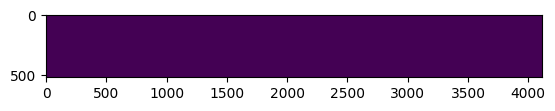

In [ ]:
import cv2
import matplotlib.pyplot as plt
testing = cv2.imread("/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/notebooks/saved_images/pred_61.png",0)
plt.imshow(testing)

  0%|                                                                                                                                                | 0/186 [00:00<?, ?it/s]/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 160, 240])) that is different to the input size (torch.Size([16, 1, 160, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 185/186 [03:39<00:01,  1.18s/it]/home/rjomega/projects/machine_learning/cityscapes-multiclass-semantic-segmentation/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15, 160, 240])) tha

current loss: 7.387522220611572


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.10it/s]


epoch : 0 ,train loss : 6.659494682024884 ,valid loss : 4.770443096756935 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.10it/s]


epoch : 1 ,train loss : 6.215003810903077 ,valid loss : 4.189766563475132 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.10it/s]

epoch : 2 ,train loss : 6.082970693547239 ,valid loss : 4.196836322546005 


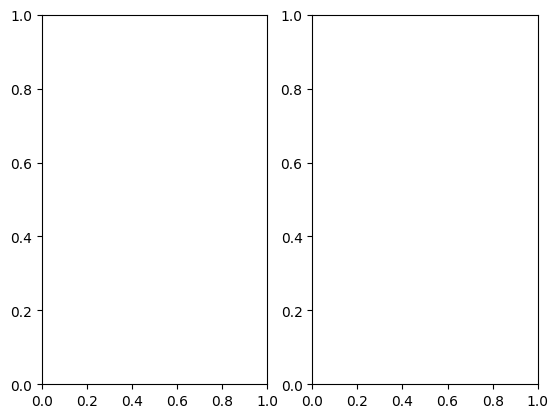

In [ ]:
fig, arr = plt.subplots(1, 2)

for i in range(epochs):
    
    trainloss = 0
    valloss = 0
    
    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    
    if(i%5==0):
        print(f"current loss: {loss}")
        # arr[0].imshow(img[0])
        # arr[1].imshow(label[0])
        # plt.show()
        # show(img,output,label)

    train_loss.append(trainloss/len(train_loader))    
  
    for img,label in tqdm(valid_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()
        
    val_loss.append(valloss/len(valid_loader))  
    
    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))



In [ ]:
output = model(img)
output.cpu()[0][0].shape

torch.Size([160, 240])

In [ ]:
img.cpu()[0].shape

torch.Size([3, 160, 240])

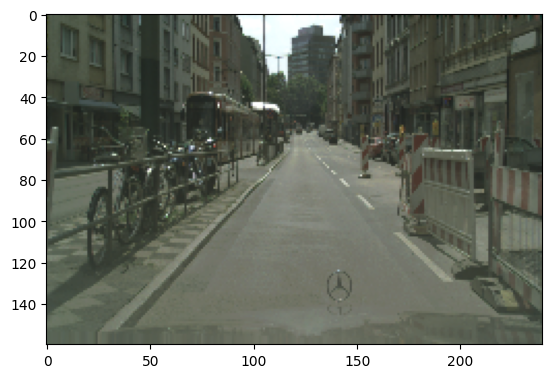

In [ ]:
plt.imshow(img.cpu()[0].permute(1,2,0))

In [ ]:
plt.imshow(label.cpu()[0][0].permute(1,2,0))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3

In [ ]:
label.cpu()[0].shape

torch.Size([160, 240])

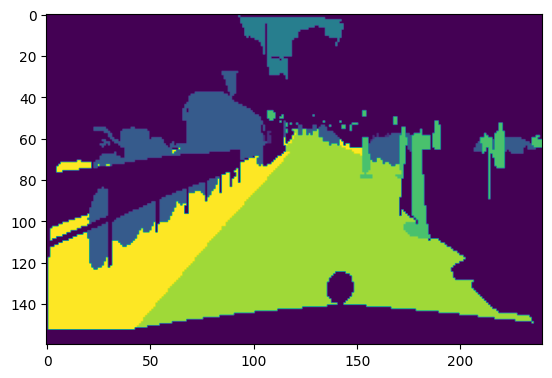

In [ ]:
plt.imshow(label.cpu()[0].detach().numpy())

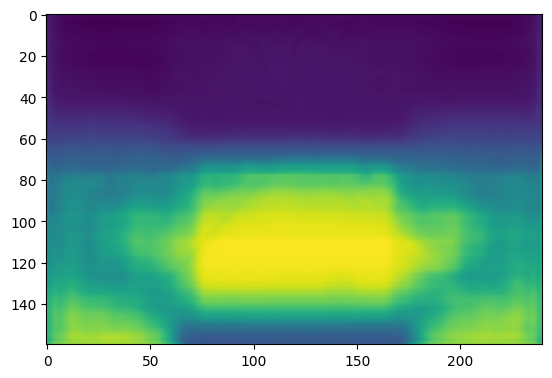

In [ ]:
plt.imshow(output.cpu()[0][0].detach().numpy())